### Base VAE Code: https://github.com/google/flax/tree/main/examples/vae
### Followed the original Theano repository of LVAE paper: https://github.com/casperkaae/LVAE
### Authors gave more details about the paper in issues: https://github.com/casperkaae/LVAE/issues/1
### Finally, in some parts I followed: https://github.com/AntixK/PyTorch-VAE/blob/master/models/lvae.py
### PS: Importance weighting is not implemented.
### Firat Oncel / oncelf@itu.edu.tr

Omniglot downlad:

In [1]:
!wget -nc https://raw.githubusercontent.com/yburda/iwae/master/datasets/OMNIGLOT/chardata.mat

File ‘chardata.mat’ already there; not retrieving.



In [3]:
!nvidia-smi

Tue Apr 26 01:21:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from tkinter.tix import Tree
from unicodedata import name
from absl import app
from absl import flags

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn

from flax.training import train_state, checkpoints
import shutil
import jax.numpy as jnp
import jax
from jax import random
import numpy as np

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf

try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds


import scipy.io
import os
import math
from PIL import Image
import matplotlib.pyplot as plt

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"

In [5]:
def plot_results(path, per):
    image = plt.imread(path)
    plt.figure(figsize=(20, per))
    plt.imshow(image)

This code is created with reference to torchvision/utils.py.
Modify: torch.tensor -> jax.numpy.DeviceArray
If you want to know about this file in detail, please visit the original code:
    https://github.com/pytorch/vision/blob/master/torchvision/utils.py

In [6]:
def save_image(ndarray, fp, nrow=8, padding=2, pad_value=0.0, format=None):
    """Make a grid of images and Save it into an image file.
    Args:
      ndarray (array_like): 4D mini-batch images of shape (B x H x W x C)
      fp - A filename(string) or file object
      nrow (int, optional): Number of images displayed in each row of the grid.
        The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
      padding (int, optional): amount of padding. Default: ``2``.
      scale_each (bool, optional): If ``True``, scale each image in the batch of
        images separately rather than the (min, max) over all images. Default: ``False``.
      pad_value (float, optional): Value for the padded pixels. Default: ``0``.
      format(Optional):  If omitted, the format to use is determined from the filename extension.
        If a file object was used instead of a filename, this parameter should always be used.
    """
    if not (
        isinstance(ndarray, jnp.ndarray)
        or (isinstance(ndarray, list) and all(isinstance(t, jnp.ndarray) for t in ndarray))
    ):
        raise TypeError("array_like of tensors expected, got {}".format(type(ndarray)))

    ndarray = jnp.asarray(ndarray)

    if ndarray.ndim == 4 and ndarray.shape[-1] == 1:  # single-channel images
        ndarray = jnp.concatenate((ndarray, ndarray, ndarray), -1)

    # make the mini-batch of images into a grid
    nmaps = ndarray.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(ndarray.shape[1] + padding), int(ndarray.shape[2] + padding)
    num_channels = ndarray.shape[3]
    grid = jnp.full((height * ymaps + padding, width * xmaps + padding, num_channels), pad_value).astype(jnp.float32)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            grid = grid.at[y * height + padding : (y + 1) * height, x * width + padding : (x + 1) * width].set(
                ndarray[k]
            )
            k = k + 1

    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = jnp.clip(grid * 255.0 + 0.5, 0, 255).astype(jnp.uint8)
    im = Image.fromarray(ndarr.copy())
    im.save(fp, format=format)

In [26]:
mnist_dict = {"learning_rate": 1e-3, "dataset_name": "mnist"}
fashion_mnist_dict = {"learning_rate": 5e-4, "dataset_name": "fashion_mnist"}
omniglot_dict = {"learning_rate": 5e-4, "dataset_name": "omniglot"}
damping = 0.75
batch_size = 256
num_epochs = 500
load_path = None
num_layers = 5
nt = 200
save_every = 25
# Taken from paper
latent_dim = [64, 32, 16, 8, 4]
hidden_dim = [512, 256, 128, 64, 32]
input_dim = 28 * 28

In [27]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [28]:
class Encoder(nn.Module):
    hidden_dim: int
    latent_dim: int

    @nn.compact
    def __call__(self, x, train):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        x = nn.BatchNorm(not train, name="bn1")(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_dim, name="fc2")(x)
        x = nn.BatchNorm(not train, name="bn2")(x)
        x = nn.leaky_relu(x)
        mean_x = nn.Dense(self.latent_dim, name="fc_m")(x)
        logvar_x = nn.Dense(self.latent_dim, name="fc_var")(x)

        return x, mean_x, jnp.clip(nn.softplus(logvar_x), 0, 10)

In [29]:
class Ladder(nn.Module):
    hidden_dim: int
    latent_dim: int

    @nn.compact
    def __call__(self, x, train):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        x = nn.BatchNorm(not train, name="bn1")(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_dim, name="fc2")(x)
        x = nn.BatchNorm(not train, name="bn2")(x)
        x = nn.leaky_relu(x)
        mean_x = nn.Dense(self.latent_dim, name="fc_m")(x)
        logvar_x = nn.Dense(self.latent_dim, name="fc_var")(x)
        return mean_x, jnp.clip(nn.softplus(logvar_x), 0, 10)

In [30]:
class Decoder(nn.Module):
    hidden_dim: int

    @nn.compact
    def __call__(self, x, train):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        x = nn.BatchNorm(not train, name="bn1")(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_dim, name="fc2")(x)
        x = nn.BatchNorm(not train, name="bn2")(x)
        x = nn.leaky_relu(x)
        return x

In [31]:
class Final(nn.Module):
    hidden_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        return nn.sigmoid(x)

In [32]:
class LVAE(nn.Module):
    latent_dims: Sequence[int]
    hidden_dims: Sequence[int]
    input_dim: int

    def setup(self):
        self.num_rungs = len(self.latent_dims)

        assert len(self.latent_dims) == len(self.hidden_dims), "Length of the latent" "and hidden dims must be the same"
        # Build Encoder
        modules = []
        for i, h_dim in enumerate(self.hidden_dims):
            modules.append(Encoder(h_dim, self.latent_dims[i]))
        self.encoders = modules

        # Build Decoder
        modules = []
        for i in range(self.num_rungs - 2, -1, -1):
            modules.append(Ladder(self.hidden_dims[i], self.latent_dims[i]))
        modules.append(Decoder(self.hidden_dims[0]))
        self.decoders = modules

        # Final layer
        self.final = Final(self.input_dim)

    def __call__(self, x, key_list, train, z=None, generate=False):
        encoded, decoded, m_s = [], [], []
        num_layers = self.num_rungs
        # First layer
        d, m, s = self.encoders[0](x, train)
        encoded.append((d, m, s))

        for i in range(1, num_layers):
            d, m, s = self.encoders[i](d, train)
            encoded.append((d, m, s))

        if not generate:
            for i in range(num_layers - 1):
                z = reparameterize(key_list[i], m, s)
                _, mu, sigma = encoded[num_layers - 2 - i]
                mu_dec, sigma_dec = self.decoders[i](z, train)
                m, s = merge_gauss(mu, mu_dec, sigma, sigma_dec)
                decoded.append((mu_dec, sigma_dec))
                m_s.append((m, s))

            z = reparameterize(key_list[-1], m, s)
            dec = self.decoders[-1](z, train)
            p_x = self.final(dec)

        else:
            for i in range(num_layers - 1):
                mu_dec, sigma_dec = self.decoders[i](z, train)
                z = reparameterize(key_list[i], mu_dec, sigma_dec)
            dec = self.decoders[-1](z, train)
            p_x = self.final(dec)

        all_mu_sigma = []  # To calculate KL Divergence
        if not generate:
            _, mu_enc_last, sigma_enc_last = encoded[-1]
            all_mu_sigma.append((mu_enc_last, sigma_enc_last))
            all_mu_sigma.append((0.0, 1.0))  # Standard normal

            for i in range(len(m_s)):
                all_mu_sigma.append(m_s[i])  # Merged
                all_mu_sigma.append(decoded[i])  # Decoder outputs

        return p_x, all_mu_sigma

In [33]:
def merge_gauss(mu_1, mu_2, log_var_1, log_var_2):
    p_1 = 1.0 / (jnp.exp(log_var_1) + 1e-7)
    p_2 = 1.0 / (jnp.exp(log_var_2) + 1e-7)
    mu = (mu_1 * p_1 + mu_2 * p_2) / (p_1 + p_2)
    log_var = jnp.log(1.0 / (p_1 + p_2))
    return mu, log_var

In [34]:
def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

In [35]:
@jax.jit
def kl_divergence(q_params, p_params):
    mu_q, log_var_q = q_params
    mu_p, log_var_p = p_params
    kl = (log_var_p - log_var_q) + (jnp.exp(log_var_q) + (mu_q - mu_p) ** 2) / (2 * jnp.exp(log_var_p) + 1e-6) - 0.5
    kl = jnp.sum(kl, axis=-1)
    return kl.mean()

In [36]:
@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = jnp.log(logits + 1e-6)
    return -jnp.sum(labels * logits + (1.0 - labels) * jnp.log(-jnp.expm1(logits)))

In [37]:
def compute_metrics(recon_x, x, kl_list):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = 0
    for i in range(0, len(kl_list), 2):
        kld_loss += kl_divergence(kl_list[i], kl_list[i + 1])

    return {"bce": bce_loss, "kld": kld_loss, "loss": bce_loss + kld_loss}

In [38]:
def model(latent_dim, hidden_dim, input_dim):
    return LVAE(latent_dim, hidden_dim, input_dim)

In [39]:
@jax.jit
def train_step(state, batch, key_list, kl_weight):
    def loss_fn(params, batch_stats):
        recon_x, kl_list = model(latent_dim, hidden_dim, input_dim).apply(
            {"params": params, "batch_stats": batch_stats}, batch, key_list, False
        )
        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = 0
        for i in range(0, len(kl_list), 2):
            kld_loss += kl_divergence(kl_list[i], kl_list[i + 1])

        loss = bce_loss + kl_weight * kld_loss
        return loss

    grads = jax.grad(loss_fn)(state.params, state.batch_stats)
    return state.apply_gradients(grads=grads)

In [40]:
@jax.jit
def eval(params, batch_stats, images, z, key_list):
    def eval_model(vae):

        recon_images, kl_list = vae(images, key_list, False)
        comparison = jnp.concatenate([images[:16].reshape(-1, 28, 28, 1), recon_images[:16].reshape(-1, 28, 28, 1)])
        generated_images, _ = vae(images, key_list, False, z, True)
        generated_images = generated_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, kl_list)

        return metrics, comparison, generated_images

    return nn.apply(eval_model, model(latent_dim, hidden_dim, input_dim))(
        {"params": params, "batch_stats": batch_stats}
    )

In [41]:
def prepare_image(x):
    x = tf.cast(x["image"], tf.float32)
    x = tf.reshape(x, (-1,))

    return x / 255

In [42]:
def prepare_dataset(dataset_name, batch_size):
    if dataset_name.startswith("omni"):
        omni_raw = scipy.io.loadmat("chardata.mat")
        train_data = np.array(omni_raw["data"].T.astype("float32"))
        test_data = np.array(omni_raw["testdata"].T.astype("float32"))
        train_ds = tf.data.Dataset.from_tensor_slices(train_data)
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(train_data.shape[0])
        train_ds = train_ds.batch(batch_size)
        train_ds = iter(tfds.as_numpy(train_ds))
        test_ds = tf.data.Dataset.from_tensor_slices(test_data).batch(test_data.shape[0])
        test_ds = np.array(list(test_ds)[0])
        test_ds = jax.device_put(test_ds)
        train_size = train_data.shape[0]

    elif dataset_name.startswith("mni"):
        ds_builder = tfds.builder("mnist")
        ds_builder.download_and_prepare()
        train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
        train_ds = train_ds.map(prepare_image)
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(50000)
        train_ds = train_ds.batch(batch_size)
        train_ds = iter(tfds.as_numpy(train_ds))
        test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
        test_ds = test_ds.map(prepare_image).batch(10000)
        test_ds = np.array(list(test_ds)[0])
        test_ds = jax.device_put(test_ds)
        train_size = 50000
    elif dataset_name.startswith("fash"):
        ds_builder = tfds.builder("fashion_mnist")
        ds_builder.download_and_prepare()
        train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
        train_ds = train_ds.map(prepare_image)
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(50000)
        train_ds = train_ds.batch(batch_size)
        train_ds = iter(tfds.as_numpy(train_ds))
        test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
        test_ds = test_ds.map(prepare_image).batch(10000)
        test_ds = np.array(list(test_ds)[0])
        test_ds = jax.device_put(test_ds)
        train_size = 50000

    return train_ds, test_ds, train_size

In [43]:
def main(exp_dict):
    learning_rate = exp_dict["learning_rate"]
    dataset_name = exp_dict["dataset_name"]
    try:
        shutil.rmtree("{}_results".format(dataset_name))
    except FileNotFoundError:
        print("Results Folder Not Found")
    os.mkdir("{}_results".format(dataset_name))
    os.mkdir("{}_results/reconstruction".format(dataset_name))
    os.mkdir("{}_results/sample".format(dataset_name))

    try:
        os.mkdir("{}_ckpts".format(dataset_name))
    except FileExistsError:
        print("Checkpoint Folder Already Exists")
    CKPT_DIR = "{}_ckpts".format(dataset_name)

    # Make sure tf does not allocate gpu memory.
    tf.config.experimental.set_visible_devices([], "GPU")
    rng = random.PRNGKey(0)
    init_key_list = []
    rng, key = random.split(rng)
    for _ in range(num_layers):
        rng, key = random.split(rng)
        init_key_list.append(key)

    train_ds, test_ds, train_size = prepare_dataset(dataset_name, batch_size)

    print("Number of train samples:", train_size)

    # Sampling z for evaluation
    eval_keys = []
    for _ in range(num_layers + 1):
        rng, key = random.split(rng)
        eval_keys.append(key)

    z = random.normal(eval_keys.pop(), (64, latent_dim[-1]))
    rng, key = random.split(rng)

    # Initialization
    init_data = random.uniform(key, (batch_size, input_dim), jnp.float32, -0.05, 0.05)
    total_steps = num_epochs * (train_size // batch_size) + num_epochs

    # LR Scheduler
    piecewise_constant_decay_scheduler = optax.piecewise_constant_schedule(
        init_value=learning_rate,
        boundaries_and_scales={
            int(total_steps * 0.1): damping,
            int(total_steps * 0.2): damping,
            int(total_steps * 0.3): damping,
            int(total_steps * 0.4): damping,
            int(total_steps * 0.5): damping,
            int(total_steps * 0.6): damping,
            int(total_steps * 0.7): damping,
            int(total_steps * 0.8): damping,
            int(total_steps * 0.9): damping,
        },
    )

    optimizer = optax.adam(learning_rate=piecewise_constant_decay_scheduler)

    # Creating train state
    rng, key = random.split(rng)
    state = TrainState.create(
        apply_fn=model(latent_dim, hidden_dim, input_dim).apply,
        params=model(latent_dim, hidden_dim, input_dim).init(key, init_data, init_key_list, True, z, False)["params"],
        tx=optimizer,
        batch_stats=model(latent_dim, hidden_dim, input_dim).init(key, init_data, init_key_list, True, z, False)[
            "batch_stats"
        ],
    )

    if load_path is not None:
        state = checkpoints.restore_checkpoint(ckpt_dir=load_path, target=state)
        print("Loaded from checkpoint!")

    steps_per_epoch = train_size // batch_size
    kl_weight = 0
    warm_up = 1 / nt

    for epoch in range(num_epochs):
        for _ in range(steps_per_epoch):
            key_list = []
            batch = next(train_ds)
            for _ in range(num_layers):
                rng, key = random.split(rng)
                key_list.append(key)
            state = train_step(state, batch, key_list, kl_weight)

        kl_weight += warm_up
        kl_weight = min(1, kl_weight)

        if not ((epoch + 1) % save_every):
            metrics, comparison, sample = eval(state.params, state.batch_stats, test_ds, z, eval_keys)
            save_image(comparison, f"{dataset_name}_results/reconstruction/{str(epoch+1).zfill(4)}.png", nrow=16)
            save_image(sample, f"{dataset_name}_results/sample/{str(epoch+1).zfill(4)}.png", nrow=16)
            print(
                "eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}".format(
                    epoch + 1, metrics["loss"], metrics["bce"], metrics["kld"]
                )
            )
            checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epoch + 1, overwrite=True)

In [44]:
main(mnist_dict)

Checkpoint Folder Already Exists
Number of train samples: 50000
eval epoch: 25, loss: 166.7463, BCE: 62.8680, KLD: 103.8783
eval epoch: 50, loss: 136.2898, BCE: 66.2952, KLD: 69.9946
eval epoch: 75, loss: 123.7053, BCE: 69.2107, KLD: 54.4946
eval epoch: 100, loss: 116.9948, BCE: 72.2173, KLD: 44.7775
eval epoch: 125, loss: 113.4768, BCE: 73.9901, KLD: 39.4867
eval epoch: 150, loss: 111.4247, BCE: 75.8911, KLD: 35.5336
eval epoch: 175, loss: 110.2382, BCE: 77.3160, KLD: 32.9222
eval epoch: 200, loss: 109.5477, BCE: 79.7355, KLD: 29.8122
eval epoch: 225, loss: 109.0232, BCE: 79.4403, KLD: 29.5828
eval epoch: 250, loss: 108.7870, BCE: 79.8357, KLD: 28.9513
eval epoch: 275, loss: 108.5609, BCE: 79.1663, KLD: 29.3946
eval epoch: 300, loss: 108.3911, BCE: 79.6712, KLD: 28.7199
eval epoch: 325, loss: 108.2359, BCE: 79.1525, KLD: 29.0833
eval epoch: 350, loss: 108.2413, BCE: 79.2207, KLD: 29.0206
eval epoch: 375, loss: 108.0587, BCE: 79.0669, KLD: 28.9918
eval epoch: 400, loss: 108.0030, BCE: 

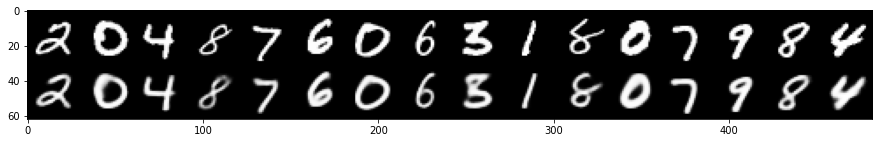

In [45]:
last = sorted(os.listdir("mnist_results/reconstruction"))[-1]
plot_results("mnist_results/reconstruction/{}".format(last), 2)

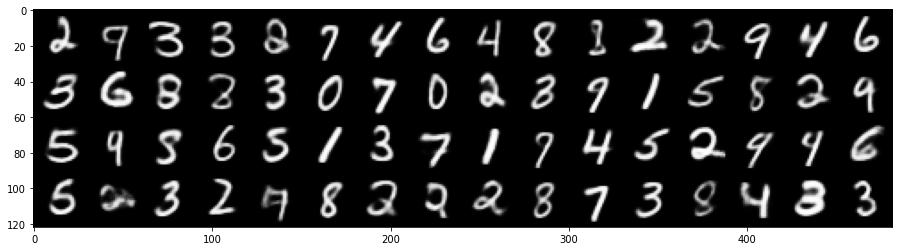

In [46]:
plot_results("mnist_results/sample/{}".format(last), 4)

In [47]:
main(fashion_mnist_dict)

Checkpoint Folder Already Exists
Number of train samples: 50000
eval epoch: 25, loss: 276.2781, BCE: 216.2462, KLD: 60.0319
eval epoch: 50, loss: 260.0321, BCE: 216.7759, KLD: 43.2562
eval epoch: 75, loss: 252.2595, BCE: 218.2319, KLD: 34.0276
eval epoch: 100, loss: 249.0534, BCE: 219.5691, KLD: 29.4842
eval epoch: 125, loss: 246.7180, BCE: 221.1043, KLD: 25.6137
eval epoch: 150, loss: 245.6497, BCE: 222.4929, KLD: 23.1568
eval epoch: 175, loss: 244.8008, BCE: 223.4040, KLD: 21.3968
eval epoch: 200, loss: 244.3741, BCE: 224.2473, KLD: 20.1268
eval epoch: 225, loss: 243.9367, BCE: 224.8377, KLD: 19.0990
eval epoch: 250, loss: 243.9056, BCE: 224.6144, KLD: 19.2912
eval epoch: 275, loss: 243.7769, BCE: 224.0140, KLD: 19.7629
eval epoch: 300, loss: 243.6983, BCE: 224.5023, KLD: 19.1961
eval epoch: 325, loss: 243.4992, BCE: 223.9664, KLD: 19.5327
eval epoch: 350, loss: 243.4699, BCE: 224.1093, KLD: 19.3605
eval epoch: 375, loss: 243.3614, BCE: 224.2394, KLD: 19.1219
eval epoch: 400, loss: 2

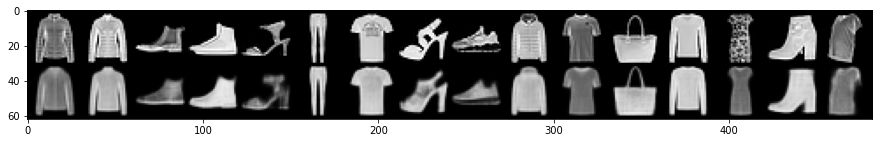

In [48]:
last = sorted(os.listdir("fashion_mnist_results/reconstruction"))[-1]
plot_results("fashion_mnist_results/reconstruction/{}".format(last), 2)

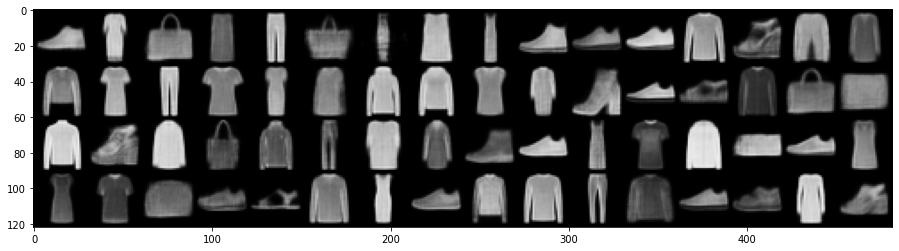

In [49]:
plot_results("fashion_mnist_results/sample/{}".format(last), 4)

In [50]:
main(omniglot_dict)

Checkpoint Folder Already Exists
Number of train samples: 24345
eval epoch: 25, loss: 206.2733, BCE: 81.0316, KLD: 125.2416
eval epoch: 50, loss: 172.5909, BCE: 82.4087, KLD: 90.1822
eval epoch: 75, loss: 157.0690, BCE: 86.1363, KLD: 70.9327
eval epoch: 100, loss: 148.9229, BCE: 90.4710, KLD: 58.4519
eval epoch: 125, loss: 143.5107, BCE: 94.0087, KLD: 49.5021
eval epoch: 150, loss: 139.9095, BCE: 98.2211, KLD: 41.6884
eval epoch: 175, loss: 138.4454, BCE: 100.6689, KLD: 37.7764
eval epoch: 200, loss: 137.1461, BCE: 105.8141, KLD: 31.3320
eval epoch: 225, loss: 136.4763, BCE: 105.1214, KLD: 31.3549
eval epoch: 250, loss: 136.3930, BCE: 105.3193, KLD: 31.0736
eval epoch: 275, loss: 136.2182, BCE: 104.6469, KLD: 31.5714
eval epoch: 300, loss: 135.9854, BCE: 105.3073, KLD: 30.6781
eval epoch: 325, loss: 135.7784, BCE: 105.1648, KLD: 30.6136
eval epoch: 350, loss: 135.7407, BCE: 105.2135, KLD: 30.5272
eval epoch: 375, loss: 135.6649, BCE: 104.3785, KLD: 31.2865
eval epoch: 400, loss: 135.63

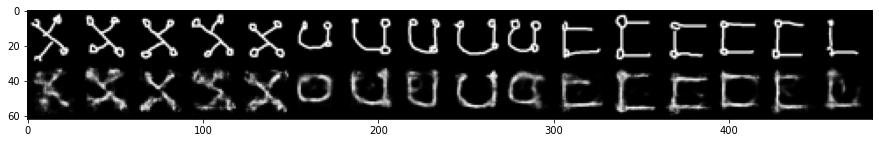

In [51]:
last = sorted(os.listdir("omniglot_results/reconstruction"))[-1]
plot_results("omniglot_results/reconstruction/{}".format(last), 2)

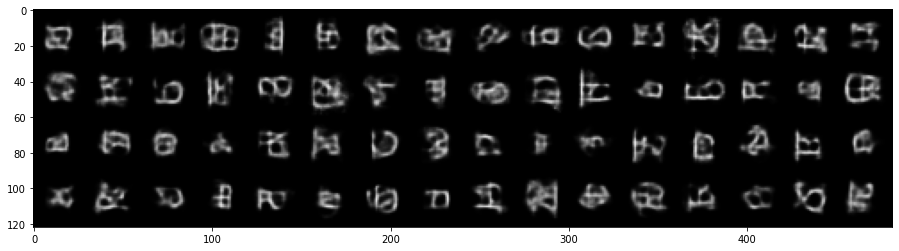

In [52]:
plot_results("omniglot_results/sample/{}".format(last), 4)